# Create Corsi timeline
a la hockeystats.cs

### Option 1: ChartMethods method

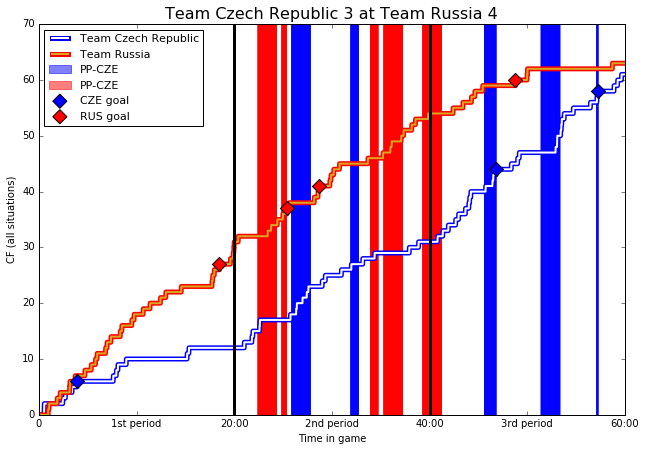

In [3]:
import ChartMethods
from pylab import *
%matplotlib inline
import PbPMethods2 as pm2
import GetPbP
import matplotlib.patheffects as path_effects

season = 2016
game = 80101
ChartMethods.game_corsi_graph(season, game, save_folder='/Users/muneebalam/Dropbox/Charts/Game H2H/World Cup/')

### Option 2: Build from scratch

Read in home name, road name, get set up

In [4]:
r = open(GetPbP.get_parsed_pbp_filename(season, game))
line = r.readline()
rname, hname = line[line.index(':') + 1:].strip().split('@')
r.close()

time_in_game = []
team1 = rname.title()
team2 = hname.title()
team1name = GetPbP.TEAM_MAP[rname]
team2name = GetPbP.TEAM_MAP[hname]
team1cf = {}
team2cf = {}

team1goals = [] #for markers
team2goals = []

Read Corsi and goal times

In [5]:
for line in pm2.read_game_corsi(season, game, strengths=['all']):
    act = pm2.get_acting_team(line)
    goal = pm2.get_event_type(line) == 'GOAL'

    if team1name is None:
        team1name = act
    elif team2name is None and not act == team1name:
        team2name = act

    time_in_game.append(pm2.convert_time(pm2.get_event_time(line), pm2.get_event_period(line)))
    if act == team1name:
        if goal:
            team1goals.append(time_in_game[-1])
        if time_in_game[-1] in team1cf:
            team1cf[time_in_game[-1]] += 1
        else:
            team1cf[time_in_game[-1]] = 1
    else:
        if goal:
            team2goals.append(time_in_game[-1])
        if time_in_game[-1] in team2cf:
            team2cf[time_in_game[-1]] += 1
        else:
            team2cf[time_in_game[-1]] = 1

toi = [i+1 for i in range(time_in_game[-1] + 1)]
cf = [0 for i in range(time_in_game[-1] + 1)]
ca = [0 for i in range(time_in_game[-1] + 1)]

time_i = 0
for i in range(1, len(toi)):
    cf[i] = cf[i-1]
    ca[i] = ca[i-1]
    if i in team1cf:
        cf[i] += 1
    if i in team2cf:
        ca[i] += 1

toadd = 0
while len(toi) < 3600:
    toadd += 1
    toi.append(toi[-1] + 1)
cf += [cf[-1]]*toadd
ca += [ca[-1]]*toadd

Read in power play times

In [6]:
team1pptimes = set()
team2pptimes = set()

prev_st = '5v5'
strength_change_times = set()
for line in pm2.read_game_toi(season, game, strengths=['all']):
    st = pm2.get_event_strength(line)
    time = int(line[0])
    if not st == prev_st:
        strength_change_times.add(time)
    if int(st[0]) > int(st[st.index('v') + 1]):
        team2pptimes.add(time)
    elif int(st[0]) < int(st[st.index('v') + 1]):
        team1pptimes.add(time)
    else:
        pass
    prev_st = st

Plot

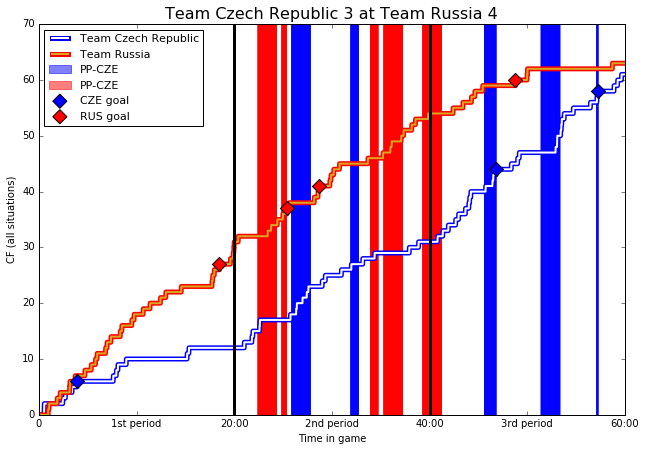

In [12]:
fig = plt.figure(figsize=[10.5, 7])

team1colors = GetPbP.get_team_colors(team1name)
team2colors = GetPbP.get_team_colors(team2name)

#Plot the PP times for team1
ppstart = None
original = False

team1pptimes = list(team1pptimes)
team1pptimes.sort()

for i in range(len(team1pptimes)):
    time = team1pptimes[i]
    if i == 0 or not team1pptimes[i-1] == time-1:
        ppstart = time
    else:
        pass
    if i == len(team1pptimes) - 1 or team1pptimes[i + 1] == time + 1:
        if not original:
            gca().axvspan(ppstart, time, alpha=0.5, color=team1colors[0], label='PP-'+team1name)
            original = True
        else:
            gca().axvspan(ppstart, time, alpha=0.5, color=team1colors[0])
        ppstart = None
    else:
        pass

#Plot PP times for team2
ppstart = None
original = False

team2pptimes = list(team2pptimes)
team2pptimes.sort()

for i in range(len(team2pptimes)):
    time = team2pptimes[i]
    if i == 0 or not team2pptimes[i-1] == time-1:
        ppstart = time
    else:
        pass
    if i == len(team2pptimes) - 1 or team2pptimes[i + 1] == time + 1:
        if not original:
            gca().axvspan(ppstart, time, alpha=0.5, color=team2colors[0], label='PP-'+team1name)
            original = True
        else:
            gca().axvspan(ppstart, time, alpha=0.5, color=team2colors[0])
        ppstart = None
    else:
        pass

#Plot Corsi timelines
team1line = plot(toi, cf, color=team1colors[1], label=team1, lw=2, zorder=1)
team1line[0].set_path_effects([path_effects.Stroke(linewidth=5, foreground=team1colors[0]),
                       path_effects.Normal()])

team2line = plot(toi, ca, color=team2colors[1], label=team2, lw=2, zorder=1)
team2line[0].set_path_effects([path_effects.Stroke(linewidth=5, foreground=team2colors[0]),
                       path_effects.Normal()])

#Scatter points denoting goals scored
gf1is = [cf[team1goals[i]] for i in range(len(team1goals))]
gf2is = [ca[team2goals[i]] for i in range(len(team2goals))]
scatter(team1goals, gf1is, marker='D', color=team1colors[0], s=100, label='{0:s} goal'.format(team1name),
            edgecolors='k', zorder=2)
scatter(team2goals, gf2is, marker='D', color=team2colors[0], s=100, label='{0:s} goal'.format(team2name),
            edgecolors='k', zorder=2)

legend(loc=2, scatterpoints=1, fontsize=11)

bot, top = plt.ylim()
periods = 1
while 1200 * periods < len(toi) - 1:
    plot([1200 * periods, 1200 * periods], [0, top], lw=3, color='k', ls='-')
    periods += 1

if len(toi) > 3600:
    xlim(0, len(toi))
else:
    xlim(0, 3600)

ylim(0, top)
xlabel('Time in game')
xlabs = '0,1st period,20:00,2nd period,40:00,3rd period,60:00'.split(',')
xticks([i for i in range(0, 3601, 600)], xlabs)
ylabel('CF (all situations)')
title('{0:s} {2:d} at {1:s} {3:d}'.format(team1, team2,
                                                            len(team1goals), len(team2goals)), size=16)
if len(toi) > 3600:
    annotate('OT', xy=(3600 + (len(toi)-3600)/2, 0), va='bottom', ha='center')